In [19]:
import torch
import torchvision

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

GTSRB = torchvision.datasets.GTSRB("", download=True)

Using cuda device


In [20]:
import os

all_files = []
for parent, dirs, files in os.walk("gtsrb"):
    all_files = all_files + [os.path.join(parent, i) for i in files if i.endswith(".ppm")]

all_files[:10]

['gtsrb/GTSRB/Training/00001/00006_00012.ppm',
 'gtsrb/GTSRB/Training/00001/00019_00012.ppm',
 'gtsrb/GTSRB/Training/00001/00007_00003.ppm',
 'gtsrb/GTSRB/Training/00001/00035_00017.ppm',
 'gtsrb/GTSRB/Training/00001/00022_00017.ppm',
 'gtsrb/GTSRB/Training/00001/00046_00019.ppm',
 'gtsrb/GTSRB/Training/00001/00046_00025.ppm',
 'gtsrb/GTSRB/Training/00001/00031_00011.ppm',
 'gtsrb/GTSRB/Training/00001/00023_00004.ppm',
 'gtsrb/GTSRB/Training/00001/00032_00028.ppm']

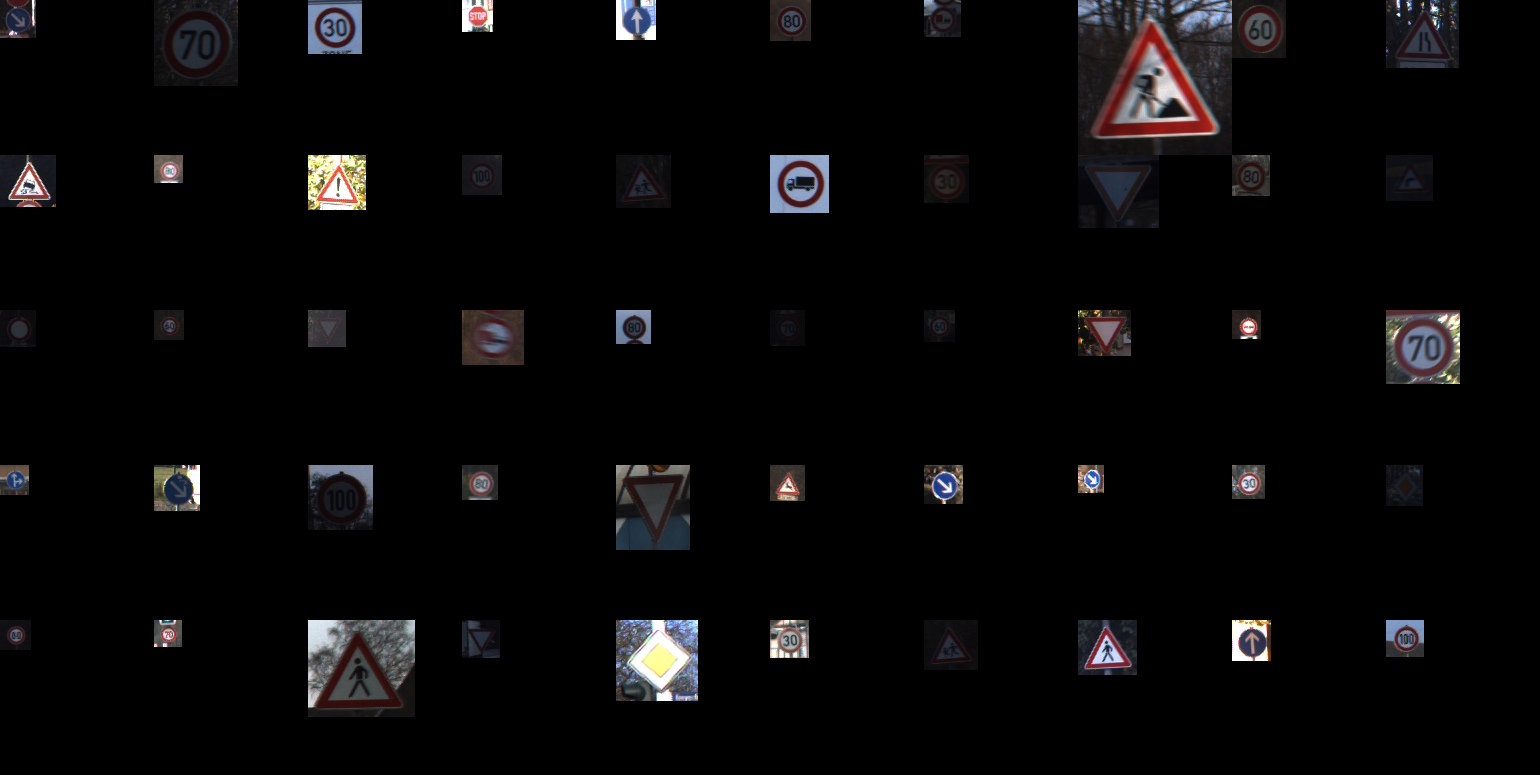

In [74]:
from PIL import Image
import random

rows, cols = 5, 10

imgs = [Image.open(i) for i in random.sample(all_files, rows * cols)]
w, h = max([i.size for i in imgs])

grid = Image.new('RGB', size=(cols * w, rows * h))
for i, img in enumerate(imgs):
    grid.paste(img, box=(i % cols * w, i // cols * h))
grid

In [22]:
sizes = [Image.open(i).size for i in random.sample(all_files, max(500, len(all_files) // 100))]
print(max(sizes))
print(min(sizes))


(182, 171)
(26, 25)


In [23]:
import polars as pl

df = pl.DataFrame({"path": all_files})
df.head()

path
str
"""gtsrb/GTSRB/Tr…"
"""gtsrb/GTSRB/Tr…"
"""gtsrb/GTSRB/Tr…"
"""gtsrb/GTSRB/Tr…"
"""gtsrb/GTSRB/Tr…"


In [24]:
def get_label_from_path(the_path: str):
    return int(the_path.split(os.sep)[-2][-2:])


df = df.with_columns(label=pl.col('path').map_elements(get_label_from_path))
df.head()

path,label
str,i64
"""gtsrb/GTSRB/Tr…",1
"""gtsrb/GTSRB/Tr…",1
"""gtsrb/GTSRB/Tr…",1
"""gtsrb/GTSRB/Tr…",1
"""gtsrb/GTSRB/Tr…",1


In [25]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

BATCH_SIZE = 1024
EPOCHS = 8
IMAGE_DIM = 100

transforms_train = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_DIM, IMAGE_DIM), antialias=True),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ColorJitter(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

transforms_test = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_DIM, IMAGE_DIM), antialias=True),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


class GtsrbDataset(Dataset):
    def __init__(self, df: pl.DataFrame, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        idx = idx.tolist() if torch.is_tensor(idx) else idx

        image = Image.open(self.df[idx, "path"])
        label = self.df[idx, "label"]

        if self.transform:
            image = self.transform(image)
        return image, label, self.df[idx, "path"]


df_train, df_test = train_test_split(df)

dataset_train = GtsrbDataset(df_train, transforms_train)
dataset_test = GtsrbDataset(df_test, transforms_test)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [38]:
EPOCHS = 15

In [39]:
# model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

loss_test_history = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}')

    model.train()
    total_loss = 0.0
    for i, data in enumerate(dataloader_train):
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss
    total_loss = total_loss / len(dataloader_train.dataset)
    print(f'Train Loss: {total_loss}')

    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels, _ in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss
    total_loss = total_loss / len(dataloader_test.dataset)
    print(f'Test Loss: {total_loss}')

    if epoch == 0 or (total_loss < min(loss_test_history)):
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        print("Model performed worse, not saving this model")

    loss_test_history.append(total_loss)

model.load_state_dict(torch.load('best_model_state.bin'))


Epoch 1
Train Loss: 0.0018867651233449578
Test Loss: 0.003148973686620593
Epoch 2
Train Loss: 0.00015150653780438006
Test Loss: 0.0011877692304551601
Epoch 3
Train Loss: 4.1834984585875645e-05
Test Loss: 0.0007116569322533906
Epoch 4
Train Loss: 2.5912262572092004e-05
Test Loss: 0.0003591473796404898
Epoch 5
Train Loss: 1.2121976396883838e-05
Test Loss: 0.00016938932822085917
Epoch 6
Train Loss: 1.0245811608911026e-05
Test Loss: 0.00013065779057797045
Epoch 7
Train Loss: 1.541165511298459e-05
Test Loss: 0.00026660013827495277
Model performed worse, not saving this model
Epoch 8
Train Loss: 1.2465485269785859e-05
Test Loss: 7.118521898519248e-05
Epoch 9
Train Loss: 9.234128810930997e-06
Test Loss: 4.808426456293091e-05
Epoch 10
Train Loss: 9.29013822315028e-06
Test Loss: 4.618795355781913e-05
Epoch 11
Train Loss: 5.311949280439876e-06
Test Loss: 3.319454117445275e-05
Epoch 12
Train Loss: 2.9071466087771114e-06
Test Loss: 3.4445412893546745e-05
Model performed worse, not saving this mode

<All keys matched successfully>

In [47]:
import polars as pl

df_val = pl.DataFrame(schema={"path": str, "predicted_label": int, "true_label": int})

model.eval()
with torch.no_grad():
    for images, labels, paths in dataloader_test:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        df_val = pl.concat([df_val, pl.DataFrame({
            "path": paths,
            "predicted_label": [int(i.cpu()) for i in preds],
            "true_label": labels.tolist(),
        })])

df_val_wrong = df_val.filter((pl.col("predicted_label") != pl.col("true_label")))
accuracy = 1 - (len(df_val_wrong) / len(df_val))
print("Accuracy:", 100 * accuracy, "%")
df_val.head()

Accuracy: 99.38438438438439 %


path,predicted_label,true_label
str,i64,i64
"""gtsrb/GTSRB/Tr…",5,5
"""gtsrb/GTSRB/Tr…",12,12
"""gtsrb/GTSRB/Tr…",3,3
"""gtsrb/GTSRB/Tr…",31,31
"""gtsrb/GTSRB/Tr…",42,42


In [49]:
gtsrb_classes = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]


df_val = df_val.with_columns(predicted_label_desc=pl.col('predicted_label').map_elements(lambda x: gtsrb_classes[x])) \
.with_columns(true_label_desc=pl.col('true_label').map_elements(lambda x: gtsrb_classes[x]))

df_val_wrong = df_val.filter((pl.col("predicted_label") != pl.col("true_label")))
print(len(df_val_wrong))
df_val_wrong.head()

41


path,predicted_label,true_label,predicted_label_desc,true_label_desc
str,i64,i64,str,str
"""gtsrb/GTSRB/Tr…",19,20,"""Dangerous curv…","""Dangerous curv…"
"""gtsrb/GTSRB/Tr…",10,3,"""No passing for…","""Speed limit (6…"
"""gtsrb/GTSRB/Tr…",1,5,"""Speed limit (3…","""Speed limit (8…"
"""gtsrb/GTSRB/Tr…",38,39,"""Keep right""","""Keep left"""
"""gtsrb/GTSRB/Tr…",38,39,"""Keep right""","""Keep left"""


In [70]:
from PIL import Image, ImageDraw

rows, cols = 11, 4
w, h = 400, 100
print(w, h)

400 100


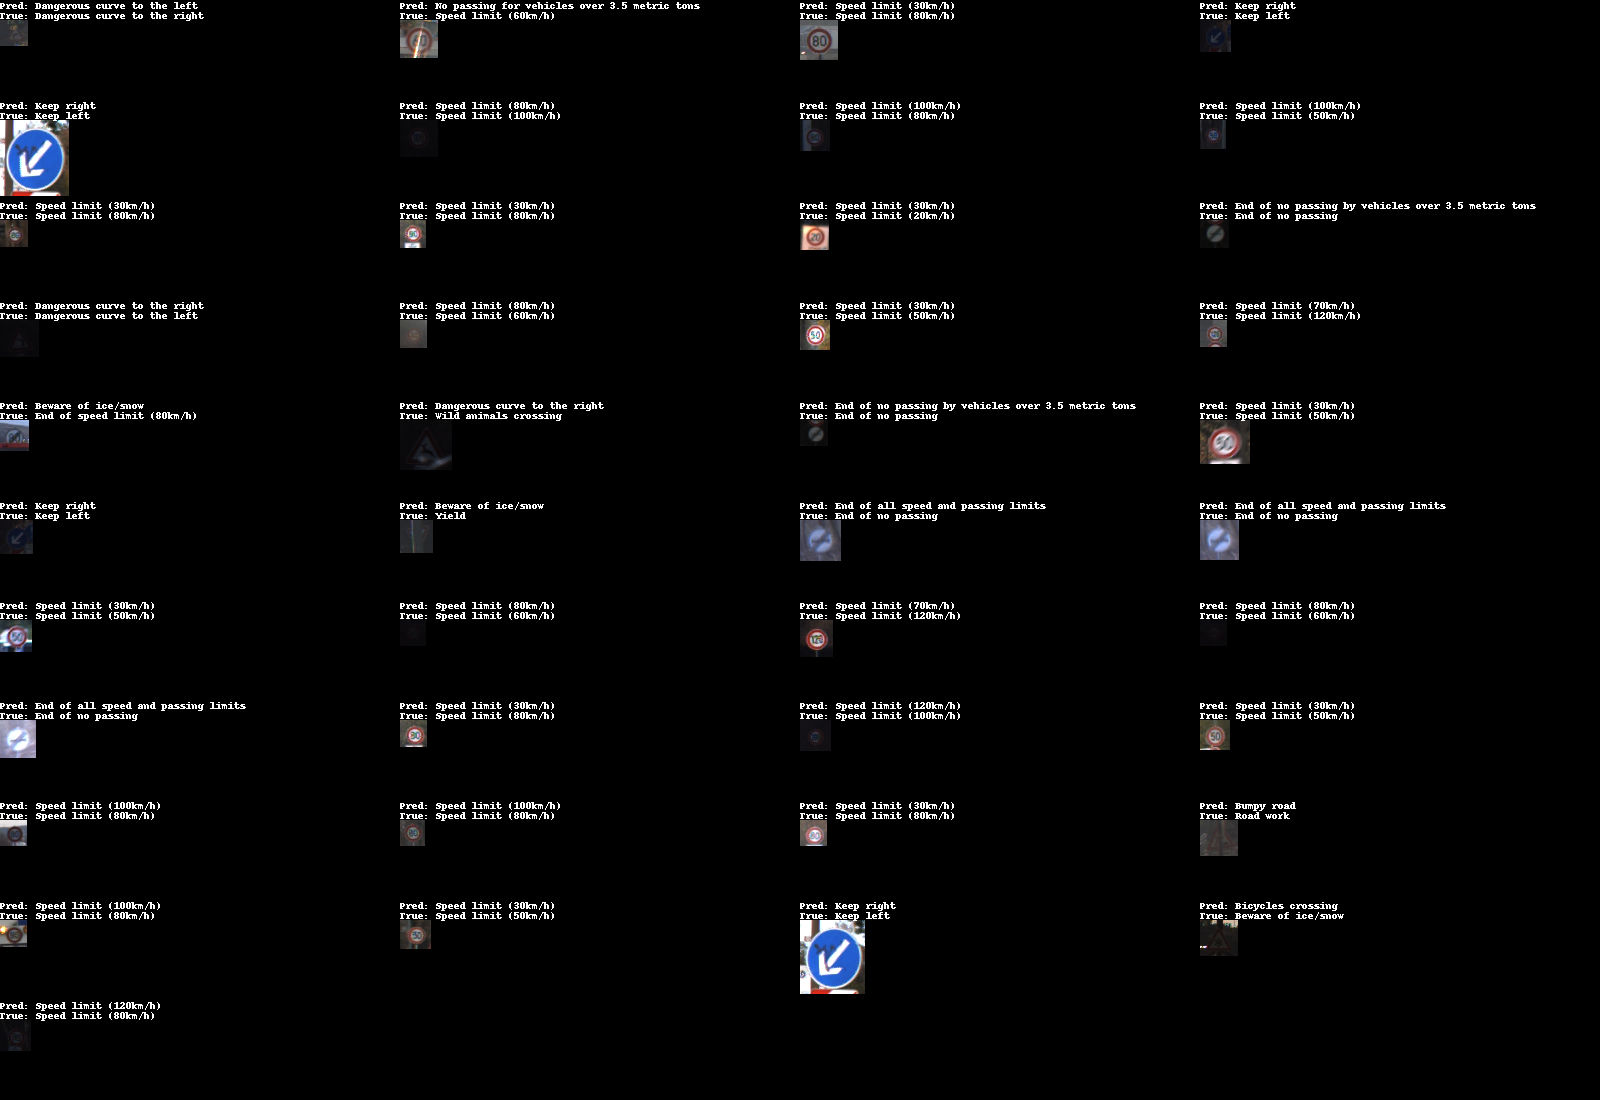

In [71]:
grid = Image.new('RGB', size=(cols * w, rows * h))

draw = ImageDraw.Draw(grid)
for i in range(len(df_val_wrong)):
  grid.paste(Image.open(df_val_wrong[i, "path"]), box=(i % cols * w, i // cols * h + 20))
  pred_txt = "Pred: " + df_val_wrong[i,"predicted_label_desc"]
  true_txt = "True: " + df_val_wrong[i,"true_label_desc"]
  draw.text((i % cols * w, i // cols * h), pred_txt, fill=(255, 255, 255), anchor="tm")
  draw.text((i % cols * w, i // cols * h + 10), true_txt, fill=(255, 255, 255), anchor="bm")

grid